In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
import json, gzip

class MNIST_Dataset(Dataset):
    def __init__(self, json_data) -> None:
        self.features = [torch.FloatTensor(i['image']) for i in json_data]
        self.labels = [torch.LongTensor([i['label']]) for i in json_data]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = None
dev_dataset = None
test_dataset = None

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    trainval_data = []
    test_data = []

    for sample in [json.loads(line) for line in file]:
        if sample['split'] == 'train':
            trainval_data.append(sample)
        else:
            test_data.append(sample)

    train_dataset = MNIST_Dataset(trainval_data[:50000])
    dev_dataset = MNIST_Dataset(trainval_data[50000:])
    test_dataset = MNIST_Dataset(test_data)

In [3]:
BATCH_SIZE = 10

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
def eval(model: nn.Module, dataloader: DataLoader, criterion: nn.Module):
        # statistics
    total_loss = 0
    total_num = 0
    # dataset loop
    for x, _ in dataloader:
        # forward pass
        x_pred = model.forward(x, detach=True)
        # update statistics
        total_loss += criterion(x_pred, x)
        total_num += x.shape[0]
    # ret
    return total_loss/total_num

In [5]:
def train(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Dev":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        # statistics
        total_loss = 0
        total_num = 0
        # dataset loop
        for x, _ in train_dataloader:
            # forward pass
            x_pred = model.forward(x)
            # calculate gradients
            loss = criterion(x_pred, x)
            loss.backward()
            # update statistics
            total_loss += criterion(x_pred, x)
            total_num += x.shape[0]
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        # output
        train_loss = total_loss/total_num
        dev_loss = eval(model, dev_dataloader, criterion)
        print(f'{f"Epoch {epoch+1}":<10} {train_loss:^10.5f} {dev_loss:^10.5f}')

### Question 2

In [47]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        pred_x = self.decoder(z)
        return pred_x
    
    def forward(self, x, detach = False):
        pred_x = self.decode(self.encode(x))
        if detach:
            pred_x = pred_x.cpu().detach()
        return pred_x

In [70]:
model = AutoEncoder()
train(model, nn.BCELoss(), optim.Adam(model.parameters(), lr=0.005), 5)

             Train       Dev    
Epoch 1     0.01585    0.01390  
Epoch 2     0.01343    0.01326  
Epoch 3     0.01303    0.01284  
Epoch 4     0.01287    0.01274  
Epoch 5     0.01277    0.01275  


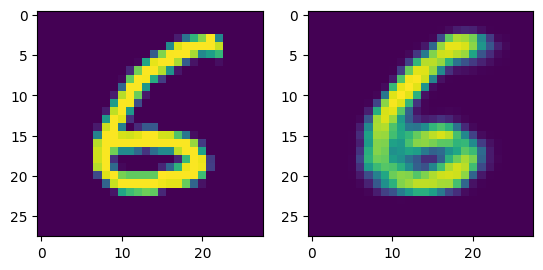

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2)

x = dev_dataset[torch.randint(0,10000,(1,))][0]
x_pred = model.forward(x, detach=True)

ax1.imshow(x.view(28,28))
ax2.imshow(x_pred.view(28,28))

plt.show()